In [6]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
from collections import Counter

In [7]:
data =  spec1d.Spec1d('../HE0435_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
#print(data)


Reading spectrum from ../HE0435_spec.fits
Expected file format: mwa
 Spectrum Start:  5570.31
 Spectrum End:     7899.01
 Dispersion (1st pixel):   0.58
 Dispersion (average):      0.58



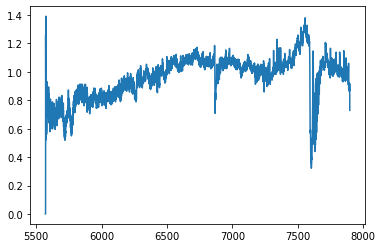

In [8]:
median_spectra_gal = np.median(data['flux'])       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
plt.plot(lamda_galaxy, spectra_galaxy_normalized)

In [9]:
c = 299792.458                                 # speed of light in km/s
frac_lamda = lamda_galaxy[1]/ lamda_galaxy[0]  # Constant lambda fraction per pixel
velocity_scale =  np.log(frac_lamda)*c         # velocity scale in km/s per pixel
print('Velocity_scale=', velocity_scale)

Velocity_scale= 31.213817586671198


In [10]:
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)

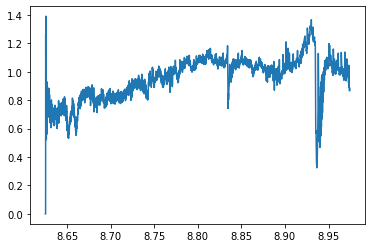

In [11]:
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)

In [12]:
template_data = spec1d.Spec1d('../TEXT/101484.txt')
lamda_template = template_data['wav']                      # wavelength in angstrom
spectra_template = template_data['flux']                     # spectra
lamda_template_range = [np.min(lamda_template), np.max(lamda_template)]
#print(lamda_template_range)


Reading spectrum from ../TEXT/101484.txt
Expected file format: text
 Spectrum Start:  3465.00
 Spectrum End:     9469.00
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



In [13]:
spectra_template_rebinned, log_lamda_template, vscale = util.log_rebin(lamda_template_range, spectra_template,
                                                                  velscale=velocity_scale)

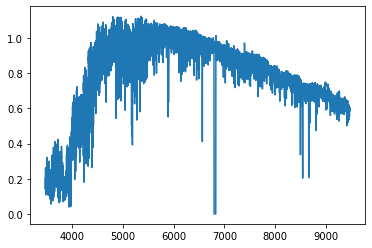

In [14]:
plt.plot(lamda_template, spectra_template)

In [15]:
fwhm_template_spectra = 1.0

def gen_sigma_diff(sig_ins):
    
    sigma_instrument = sig_ins                           #sigma of the instrumental LSF
    fwhm_galaxy = 2.355 * sigma_instrument           # FWHM of every pixel in Angstrom
    fwhm_galaxy_spectra  = np.full(len(lamda_galaxy), fwhm_galaxy)
    
    fwhm_interp_gal_spec = np.interp(lamda_template, lamda_galaxy, fwhm_galaxy_spectra)  #interpolated fwhm
    fwhm_diff = np.sqrt(fwhm_interp_gal_spec**2 - fwhm_template_spectra**2)
    sigma_diff = fwhm_diff / 2.355
    
    return sigma_diff

In [16]:
sigma_instrument = 0.95
sigma_diff = gen_sigma_diff(sigma_instrument)

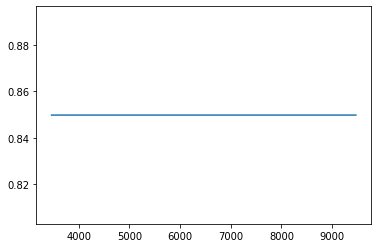

In [17]:
plt.plot(lamda_template, sigma_diff)

In [13]:
dv = c*np.log(lamda_template[0]/lamda_galaxy[0]) 

In [14]:
z = 0.454              # redshift from input spectra
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  
#print(vel)

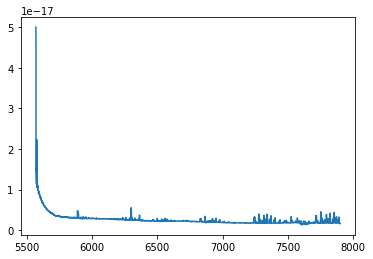

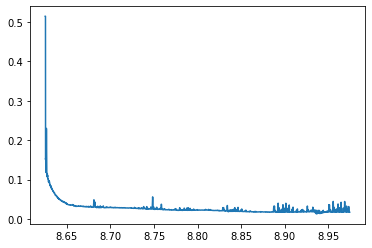

In [15]:
sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range,
                                                             noise,
                                                           velscale=velocity_scale)
plt.plot(lamda_galaxy, sigma_galaxy_spectra)
plt.figure()
#print(velo_scale)
#print(np.size(noise_new))
plt.plot(log_lamda_noise, noise_rebinned)

In [16]:
def masking(length, pixel_range, log_lamda_gal):
    '''
    This function generate and returns a boolean array with value 'False'
    in the pixel locations which should be excluded from the fit.
    
    Parameters
    ---------------
    length: int
        The length of the logarithmically rebinned galaxy spectra. The 
        boolean array would be of the same size.
        
    pixel_range: list
        A list of tuples where each tuple contains start and end of the
        pixel range needs to be excluded.
        
    log_lamda_gal: array
        This array contains the values of the logarithmically 
        rebinned wavelengths.
    
    Returns
    -------------
    mask : boolean array
        Boolean array with with value 'False' in the pixel locations 
        which should be excluded from the fit.
        
    '''
    
    mask = np.zeros(length, dtype=bool)
    for i,p in enumerate(pixel_range):
        mask |= (log_lamda_gal>=p[0]) & (log_lamda_gal <= p[1])
    return (~mask)

In [17]:
pixel_range = [[(8.8305, 8.8422), (8.91412, 8.94774)], [(8.6252, 8.62938), (8.8268, 8.84623),
                (8.91133, 8.9749)], [(8.6236, 8.6352), (8.82, 8.9749)]]

In [18]:
def gen_rebinned_templates(temp_num, temp_array, sigma_diff):
    
    filename = []
    
    if(temp_num):
        indo_us_library = glob.glob('../TEXT/*')[:temp_num]
        templates = np.empty((spectra_template_rebinned.size, len(indo_us_library)))
    

        for j, file_name in enumerate(indo_us_library):
        
            filename.append(file_name)
        
            template_data = spec1d.Spec1d(file_name, verbose=False)
            template_spectra = template_data['flux']

            # perform convolution with variable sigma_diff    
            convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

            template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
            templates[:, j] = template_spectra_rebinned / np.median(template_spectra_rebinned) # Normalizes 
                                                                                           # templates
        return templates, filename
    else:
        
        templates = np.empty((spectra_template_rebinned.size, len(temp_array)))
        
        for j, file_name in enumerate(temp_array):
        
            filename.append(file_name)
        
            template_data = spec1d.Spec1d(file_name, verbose=False)
            template_spectra = template_data['flux']

            # perform convolution with variable sigma_diff    
            convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

            template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
            templates[:, j] = template_spectra_rebinned / np.median(template_spectra_rebinned) # Normalizes 
                                                                                           # templates
        return templates, filename

In [23]:
def add_noise_to_spectra():
    
    spectra_galaxy_with_noise = np.zeros(len(spectra_galaxy))
    noise_gal_spec = np.zeros(len(spectra_galaxy))
    
    for i,p in enumerate(spectra_galaxy):
    
        noise_gal_spec[i] = np.random.normal(0, np.sqrt(variance_spectra_galaxy[i]))
        spectra_galaxy_with_noise[i] = p + noise_gal_spec[i]
    
    return (spectra_galaxy_with_noise / np.median(spectra_galaxy_with_noise))


In [24]:
used_file_data = []
with open('used_templates.txt', 'r') as file:
        
        for line in file:
            used_file_data.append(line.strip())

In [25]:
cnt = Counter()
for i, p in enumerate(used_file_data):
        
        cnt[p] += 1

In [26]:
total_template_set = []
for i,p in enumerate(cnt):
    total_template_set.append(p)

In [27]:
odd_template = '../TEXT/147700.txt'
total_template_set.remove(odd_template)


with degree 4 : 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112221       225    -0.031    -0.044
chi2/DOF: 0.779
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 20
Templates weights:
         0         0         0    0.0718         0         0         0      0.29         0         0   0.00485         0         0     0.071    0.0624         0   0.00183         0         0         0

with degree 5 : 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112221       225    -0.032    -0.045
chi2/DOF: 0.7785
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 20
Templates weights:
         0         0         0    0.0686         0         0         0     0.295         0         0   0.00364         0         0    0.0694    0.0574         0   0.00287         0         0         0

with degree 6 : 

 Best Fit:       Vel     sigma        

<Figure size 432x288 with 0 Axes>

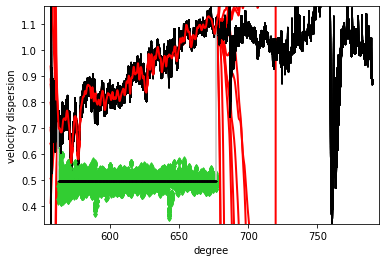

<Figure size 432x288 with 0 Axes>

In [30]:
templates, file_name = gen_rebinned_templates(0, sample(total_template_set, 20), sigma_diff)
    
mask = masking(spectra_galaxy_rebinned.size, pixel_range[2], log_lamda_galaxy)
    
#fl.append(file_name)

degree = np.arange(4,21)
velocity_dispersion = np.zeros(len(degree))
for i in range(len(degree)):
    print('\nwith degree %d : \n' %degree[i])
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
#    plt.figure()
    
# pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
#        plot=True, vsyst=dv, degree=12, mask=mask, lam=np.exp(log_lamda_galaxy), quiet=False)


<Figure size 432x288 with 0 Axes>

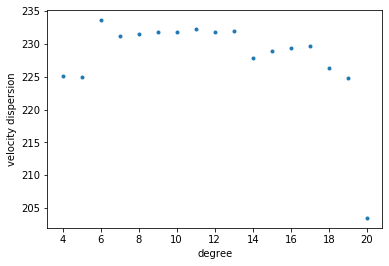

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()


with degree 4 : 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112221       231    -0.019    -0.018
chi2/DOF: 0.7644
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 850

with degree 5 : 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112220       232    -0.019    -0.019
chi2/DOF: 0.7637
method = capfit; Jac calls: 2; Func calls: 12; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  15 / 850

with degree 6 : 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112228       243    -0.010     0.005
chi2/DOF: 0.7236
method = capfit; Jac calls: 3; Func calls: 19; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 850

with degree 7 : 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112231       240    -0.005     0.009
chi2/DOF: 0.7144
method = capfit; Jac calls: 4; Func calls: 22; Status: 3
linear_method = nnls; Nonzero Templates (>0

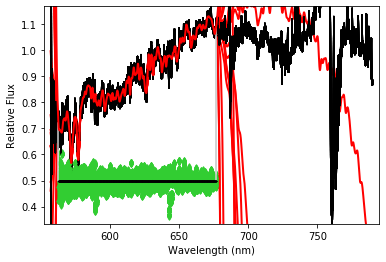

In [76]:
templates, file_name = gen_rebinned_templates(850, 0, sigma_diff)
    
mask = masking(spectra_galaxy_rebinned.size, pixel_range[2], log_lamda_galaxy)

weight = []
    
#fl.append(file_name)

degree = np.arange(4,21)
velocity_dispersion = np.zeros(len(degree))
for i in range(len(degree)):
    print('\nwith degree %d : \n' %degree[i])
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    weight.append(pp.weights)
#    plt.figure()
    
# pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
#        plot=True, vsyst=dv, degree=12, mask=mask, lam=np.exp(log_lamda_galaxy), quiet=False)


<Figure size 432x288 with 0 Axes>

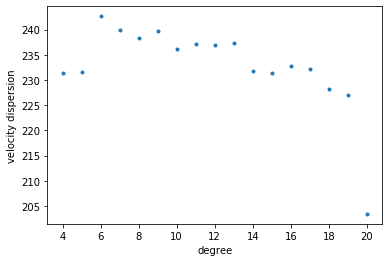

<Figure size 432x288 with 0 Axes>

In [77]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [83]:
f_name = []
for j, p in enumerate(weight):
    temp_index = []
    for k, w in enumerate(p):
    
        if w > 0:
            temp_index.append(k)
    #print(temp_index)
#used_template = []
    for k, index in enumerate(temp_index):
    
        f_name.append(file_name[index])

In [84]:
cnt_1 = Counter()
for i, p in enumerate(f_name):
        
        cnt_1[p] += 1

In [86]:
len(cnt_1)

51

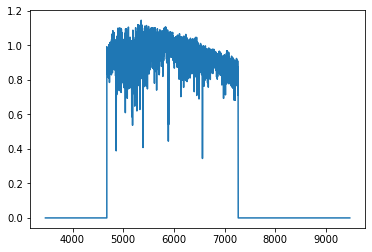

In [53]:
plt.plot(lamda_template, te['flux'])

In [ ]:
velocity_dispersion = []
chi_2 = []
f = open('vel_dis_MC_new_mask.txt', 'w+')


for i in range(500):
    
    spec_gal_w_noise = add_noise_to_spectra()
    spec_gal_w_noise_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, 
                                                               spec_gal_w_noise, 
                                                               velscale=velocity_scale)
    mask = masking(spec_gal_w_noise_rebinned.size, pixel_range[2], log_lamda_galaxy)
    pp = ppxf(templates, spec_gal_w_noise_rebinned, noise_rebinned, velocity_scale, start, moments=4,
              plot=True, vsyst=dv, degree=12, mask= mask, lam=np.exp(log_lamda_galaxy), quiet=True)
    
    velocity_dispersion.append(pp.sol[1])
    chi_2.append(pp.chi2)
    f.write("velocity dispersion: %d km/s; chi^2: %f;\n" %(round(pp.sol[1]), pp.chi2))

f.close()

std = 9.711603
mean = 237.134503


Text(0.5, 0, 'velocity dispersion')

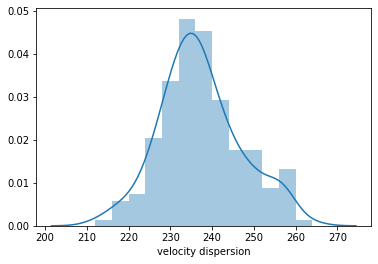

In [90]:
p = pd.read_csv('vel_dis_MC_new_mask.txt', delimiter=' ', header=None)
vel = p[2]
print('std = %f' %np.std(vel))
print('mean = %f' %np.mean(vel))
sn.distplot(vel)
plt.xlabel('velocity dispersion')

In [ ]:
velocity_dispersion = []
chi_2 = []
f = open('vel_dis_MC_with_degree.txt', 'w+')

fl = []

for i in range(800):
    
    #spec_gal_w_noise = add_noise_to_spectra()
    #spec_gal_w_noise_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, 
    #                                                           spec_gal_w_noise, 
    #                                                          velscale=velocity_scale)
    #mask = masking(spec_gal_w_noise_rebinned.size, pixel_range_new, log_lamda_galaxy)
    templates, file_name = gen_rebinned_templates(0, sample(total_template_set, 20), sigma_diff)
    
    mask = masking(spectra_galaxy_rebinned.size, pixel_range[1], log_lamda_galaxy)
    
    fl.append(file_name)
    
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, degree=12, mask=mask, lam=np.exp(log_lamda_galaxy), quiet=True)
    
    velocity_dispersion.append(pp.sol[1])
    chi_2.append(pp.chi2)
    f.write("velocity dispersion: %d km/s; chi^2: %f;\n" %(round(pp.sol[1]), pp.chi2))

f.close()